In [77]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [39]:
data = pd.read_csv('std_df_full.csv', index_col=False)
data.head()

,Unnamed: 0,vaxView,year,value,lowerLimit,upperLimit,sampleSize,confidenceInterval,demographicClass,upperError,lowerError
0,0,0.000000,2001,92.2,0.897545,0.940022,0.015281,0.071429,0.000000,0.072797,0.055556
1,1,0.000000,2003,77.3,0.601921,0.869138,0.000689,0.415584,0.083333,0.394636,0.364734
2,2,0.000000,2010,75.7,0.677695,0.801527,0.008674,0.198052,0.000000,0.218391,0.154589
3,3,0.000000,2017,76.9,0.750267,0.766630,0.326354,0.035714,0.166667,0.049808,0.019324
4,4,0.333333,2015,45.3,0.353255,0.483097,0.012380,0.217532,0.000000,0.264368,0.154589


In [40]:
data.drop(['Unnamed: 0', 'upperLimit', 'upperError', 'confidenceInterval'], axis=1, inplace=True)

In [41]:
corr = data.corr()

In [42]:
corr

,vaxView,year,value,lowerLimit,sampleSize,demographicClass,lowerError
vaxView,1.000000,0.417557,-0.398359,-0.389750,0.063994,0.057740,0.019109
year,0.417557,1.000000,-0.102136,-0.119767,0.000433,0.217980,0.090604
value,-0.398359,-0.102136,1.000000,0.972857,-0.093155,-0.026033,-0.024076
lowerLimit,-0.389750,-0.119767,0.972857,1.000000,-0.028587,-0.064287,-0.254763
sampleSize,0.063994,0.000433,-0.093155,-0.028587,1.000000,-0.082367,-0.265775
demographicClass,0.057740,0.217980,-0.026033,-0.064287,-0.082367,1.000000,0.168944
lowerError,0.019109,0.090604,-0.024076,-0.254763,-0.265775,0.168944,1.000000


### Removing features with correlation > 0.9

In [43]:
# columns = np.full((corr.shape[0],), True, dtype=bool)
# for i in range(corr.shape[0]):
#     for j in range(i+1, corr.shape[0]):
#         if corr.iloc[i,j] >= 0.9:
#             if columns[j]:
#                 columns[j] = False
# selected_columns = data.columns[columns]
# selected_columns

In [45]:
y = data['value']  # assign the predictor to y
X = data.drop(['value'], axis=1).astype('float64')  # dropping the predictor

In [46]:
def get_stats():
    results = sm.OLS(y, X).fit()
    print(results.summary())

In [47]:
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.894e+09
Date:                Fri, 07 May 2021   Prob (F-statistic):                        0.00
Time:                        14:06:12   Log-Likelihood:                          4889.5
No. Observations:                1808   AIC:                                     -9767.
Df Residuals:                    1802   BIC:                                     -9734.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [48]:
# X.drop(columns=['vaxView', 'confidenceInterval', 'demographicClass', 'year'], inplace=True)

In [49]:
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.894e+09
Date:                Fri, 07 May 2021   Prob (F-statistic):                        0.00
Time:                        14:06:13   Log-Likelihood:                          4889.5
No. Observations:                1808   AIC:                                     -9767.
Df Residuals:                    1802   BIC:                                     -9734.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

## Best subset selection

In [50]:
X = data.drop(['value'], axis=1).astype('float64') 

In [51]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    X_data = sm.add_constant(X)
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS, "AIC": regr.aic,  "BIC": regr.bic, "features": list(feature_set)}

In [52]:
def getBest(k):
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))

    models = pd.DataFrame(results)

    df = models[models['AIC'] == models['AIC'].min()]

    best_model_aic = df.iloc[0]

    print("Processed", models.shape[0], "models on", k, "predictors")

    return best_model_aic

In [54]:
models_best = pd.DataFrame(columns=["RSS", "model", "AIC", "BIC", "features"])

for i in range(1,7):
    models_best.loc[i] = getBest(i)

Processed 6 models on 1 predictors
Processed 15 models on 2 predictors
Processed 20 models on 3 predictors
Processed 15 models on 4 predictors
Processed 6 models on 5 predictors
Processed 1 models on 6 predictors


Text(0, 0.5, 'BIC')

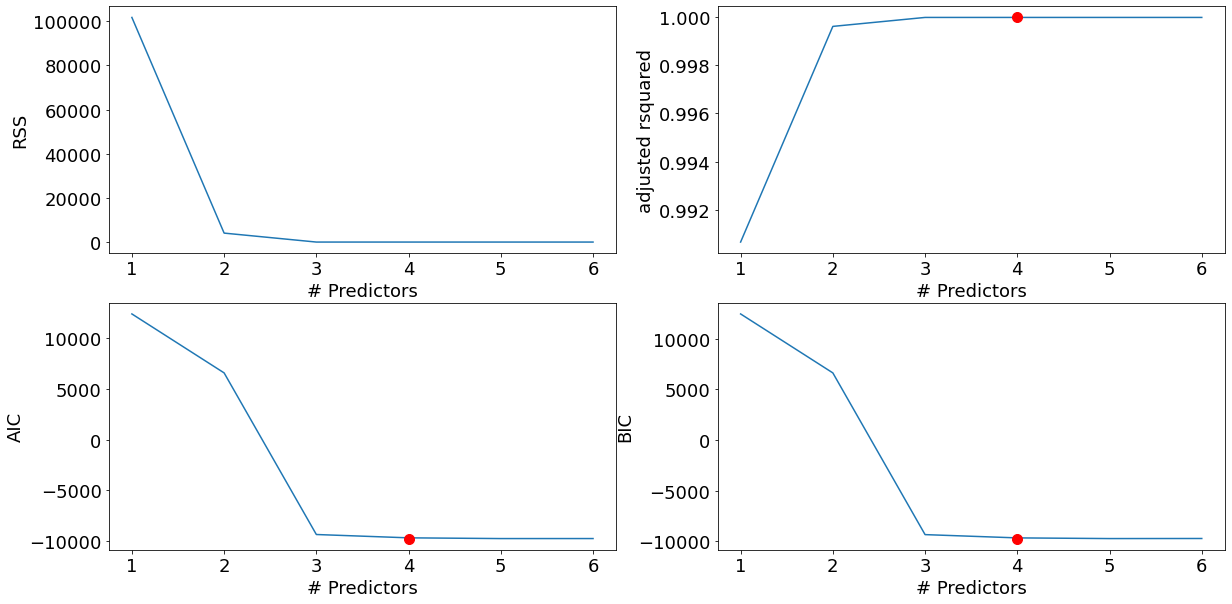

In [55]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

print("\n")

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')



### Model with lowest AIC value

In [56]:
print(models_best.loc[models_best['AIC'] == models_best['AIC'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          8.277e+09
Date:                Fri, 07 May 2021   Prob (F-statistic):                        0.00
Time:                        14:06:25   Log-Likelihood:                          4889.4
No. Observations:                1808   AIC:                                     -9769.
Df Residuals:                    1803   BIC:                                     -9741.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

### Model with lowest BIC value

In [57]:
print(models_best.loc[models_best['BIC'] == models_best['BIC'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          8.277e+09
Date:                Fri, 07 May 2021   Prob (F-statistic):                        0.00
Time:                        14:06:26   Log-Likelihood:                          4889.4
No. Observations:                1808   AIC:                                     -9769.
Df Residuals:                    1803   BIC:                                     -9741.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

### Model with lowest RSS value

In [58]:
models_best.loc[models_best['RSS'] == models_best['RSS'].min()]

,RSS,model,AIC,BIC,features
6,0.473982,<statsmodels.regression.linear_model.Regressio...,-9766.902621,-9733.902762,"[vaxView, year, lowerLimit, sampleSize, demogr..."


In [59]:
print(models_best.loc[models_best['RSS'] == models_best['RSS'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.894e+09
Date:                Fri, 07 May 2021   Prob (F-statistic):                        0.00
Time:                        14:06:26   Log-Likelihood:                          4889.5
No. Observations:                1808   AIC:                                     -9767.
Df Residuals:                    1802   BIC:                                     -9734.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

## Forward stepwise regression

In [60]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]

    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    df = models[models['AIC'] == models['AIC'].min()]

    best_model = df.iloc[0]

    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [61]:
models_fwd = pd.DataFrame(columns=["RSS", "model", "AIC", "BIC", "features"])

predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names


Processed  6 models on 1 predictors
Processed  5 models on 2 predictors
Processed  4 models on 3 predictors
Processed  3 models on 4 predictors
Processed  2 models on 5 predictors
Processed  1 models on 6 predictors


In [62]:
print(models_fwd.loc[models_fwd['AIC'] == models_fwd['AIC'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          8.277e+09
Date:                Fri, 07 May 2021   Prob (F-statistic):                        0.00
Time:                        14:06:28   Log-Likelihood:                          4889.4
No. Observations:                1808   AIC:                                     -9769.
Df Residuals:                    1803   BIC:                                     -9741.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [63]:
print(models_fwd.loc[models_fwd['BIC'] == models_fwd['BIC'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          8.277e+09
Date:                Fri, 07 May 2021   Prob (F-statistic):                        0.00
Time:                        14:06:29   Log-Likelihood:                          4889.4
No. Observations:                1808   AIC:                                     -9769.
Df Residuals:                    1803   BIC:                                     -9741.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [64]:
print(models_fwd.loc[models_fwd['RSS'] == models_fwd['RSS'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.894e+09
Date:                Fri, 07 May 2021   Prob (F-statistic):                        0.00
Time:                        14:06:30   Log-Likelihood:                          4889.5
No. Observations:                1808   AIC:                                     -9767.
Df Residuals:                    1802   BIC:                                     -9734.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [65]:
models_fwd.loc[models_fwd['RSS'] == models_fwd['RSS'].min()]

,RSS,model,AIC,BIC,features
6,0.473982,<statsmodels.regression.linear_model.Regressio...,-9766.902621,-9733.902762,"[lowerLimit, lowerError, year, vaxView, demogr..."


### Backward Stepwise Regression

In [66]:
def backward(predictors):

    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    df = models[models['AIC'] == models['AIC'].min()]

    best_model = df.iloc[0]
    
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [67]:
models_bwd = pd.DataFrame(columns=["RSS", "model", "AIC", "BIC", "features"], index = range(1,len(X.columns)))

predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names


Processed  6 models on 5 predictors
Processed  5 models on 4 predictors
Processed  4 models on 3 predictors
Processed  3 models on 2 predictors
Processed  2 models on 1 predictors


In [68]:
print(models_bwd.loc[models_bwd['AIC'] == models_bwd['AIC'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          8.277e+09
Date:                Fri, 07 May 2021   Prob (F-statistic):                        0.00
Time:                        14:06:31   Log-Likelihood:                          4889.4
No. Observations:                1808   AIC:                                     -9769.
Df Residuals:                    1803   BIC:                                     -9741.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [69]:
print(models_bwd.loc[models_bwd['BIC'] == models_bwd['BIC'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          8.277e+09
Date:                Fri, 07 May 2021   Prob (F-statistic):                        0.00
Time:                        14:06:32   Log-Likelihood:                          4889.4
No. Observations:                1808   AIC:                                     -9769.
Df Residuals:                    1803   BIC:                                     -9741.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [70]:
print(models_bwd.loc[models_bwd['RSS'] == models_bwd['RSS'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          8.277e+09
Date:                Fri, 07 May 2021   Prob (F-statistic):                        0.00
Time:                        14:06:32   Log-Likelihood:                          4889.4
No. Observations:                1808   AIC:                                     -9769.
Df Residuals:                    1803   BIC:                                     -9741.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [71]:
models_bwd.loc[models_bwd['RSS'] == models_bwd['RSS'].min()]

,RSS,model,AIC,BIC,features
5,0.474011,<statsmodels.regression.linear_model.Regressio...,-9768.79,-9741.29,"[vaxView, year, lowerLimit, demographicClass, ..."


### The features giving lowest AIC, BIC and RSS values Backward regression are upperLimit, upperError and year and the features giving lowest AIC, BIC and RSS values for best subset selection and Forward are upperLimit, upperError and lowerError

#### Fitting a model with all these features

In [72]:
X = data[[ "vaxView", "lowerLimit", "lowerError", "year", "demographicClass"]]

In [73]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [74]:
model = sm.OLS(y_train, X_train).fit()
y_pred = model.predict(X_test)

In [78]:
print("MSE", mean_squared_error(y_test, y_pred))  

MSE 0.00026831265588524443


In [79]:
from math import sqrt
print("RMSE", sqrt(mean_squared_error(y_test, y_pred)))

RMSE 0.016380252009210495


In [ ]:
print(model.summary())

In [ ]:
aic_bwd = models_bwd.loc[models_bwd['AIC'] == models_bwd['AIC'].min()]["AIC"].tolist()[0]
aic_fwd = models_fwd.loc[models_fwd['AIC'] == models_fwd['AIC'].min()]["AIC"].tolist()[0]

In [ ]:
aic_bwd > aic_fwd

In [ ]:
aic_fwd > aic_bwd

In [ ]:
from sklearn.metrics import r2_score
import seaborn as sns
r2_score(y_test, y_pred = y_pred)

In [ ]:
# Plotting the predicted values against the actual values
sns.distplot(y_pred, hist = False, color = 'y', label = 'Predicted')
sns.distplot(y_test, hist = False, color = 'r', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10)
plt.legend(loc = 'upper left', fontsize = 10)

# plt.savefig('ap.png')